# Livrable 2 - Denoising d'images

|Auteurs|
|---|
|Frédéric SPATARO|
|Oscar PALISSOT|
|Djayan DEMAISON|
|Arnaud HITTINGER|
|Nicolas PELLEGRINI|

# 1. Introduction

## 1.1. Présentation du problème de débruitage d'image

Le débruitage d'images, ou denoising, est une étape cruciale dans le prétraitement des données, en particulier dans le contexte des données numérisées. Les images numérisées, surtout celles qui proviennent de documents papier, peuvent présenter divers degrés de bruit sous forme de points, de stries ou d'autres artefacts visuels qui peuvent potentiellement interférer avec les analyses ultérieures, telles que la classification ou la génération de légendes. Le débruitage est donc essentiel pour assurer la précision et la fiabilité des modèles de machine learning qui seront appliqués par la suite.

## 1.2. Objectifs du Notebook

L'objectif de ce notebook est de mettre en œuvre une solution de débruitage d'images en utilisant des auto-encodeurs convolutifs. Nous chercherons à :

- Préparer les données d'images pour l'entraînement du modèle.
- Construire et entraîner un auto-encodeur convolutif pour le débruitage d'images.
- Évaluer les performances du modèle et visualiser les résultats.
- Fournir une analyse critique des résultats et identifier les domaines potentiels d'amélioration.

## 1.3. Qu'est ce qu'un auto-encodeur ?

Les auto-encodeurs sont un type de réseau de neurones utilisé pour l'apprentissage non supervisé. Ils visent à apprendre une représentation (encodage) efficace des données, généralement dans le but de réduire la dimensionnalité. Un auto-encodeur est structuré en deux parties principales :

- Encodeur : Il apprend à compresser l'entrée dans une forme latente, souvent de dimensionnalité réduite.
- Décodeur : Il apprend à reconstruire l'entrée à partir de cette forme latente.

Dans le contexte du débruitage d'images, les auto-encodeurs sont entraînés pour mapper des images bruitées à leurs versions propres, en apprenant à supprimer le bruit tout en conservant les caractéristiques importantes des données.

# 2. Importation et exploration des données

## 2.1. Importation des bibliothèques nécessaires

In [175]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

print("Import terminé.")

Import terminé.


## 2.2. Chargement du dataset d'images

In [176]:
data_dir = 'DataL2'
image_files = os.listdir(data_dir)

# Paramètres des images
img_height, img_width, rgb = 256, 256, 3
input_img = Input(shape=(img_height, img_width, rgb))
images = []

for img_file in image_files:
    img_path = os.path.join(data_dir, img_file)
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    images.append(img_array)

images = np.array(images)

print("Chargement terminé.")

Chargement terminé.


## 2.3. Exploration des données

In [177]:
# Afficher quelques informations de base sur les données
print(f"Nombre total d'images : {images.shape[0]}")
print(f"Dimensions des images : {images.shape[1:]}")
print(f"Valeur min des pixels : {np.min(images)}")
print(f"Valeur max des pixels : {np.max(images)}")

Nombre total d'images : 148
Dimensions des images : (256, 256, 3)
Valeur min des pixels : 0.0
Valeur max des pixels : 255.0


## 2.4. Visualisation d'exemples d'images

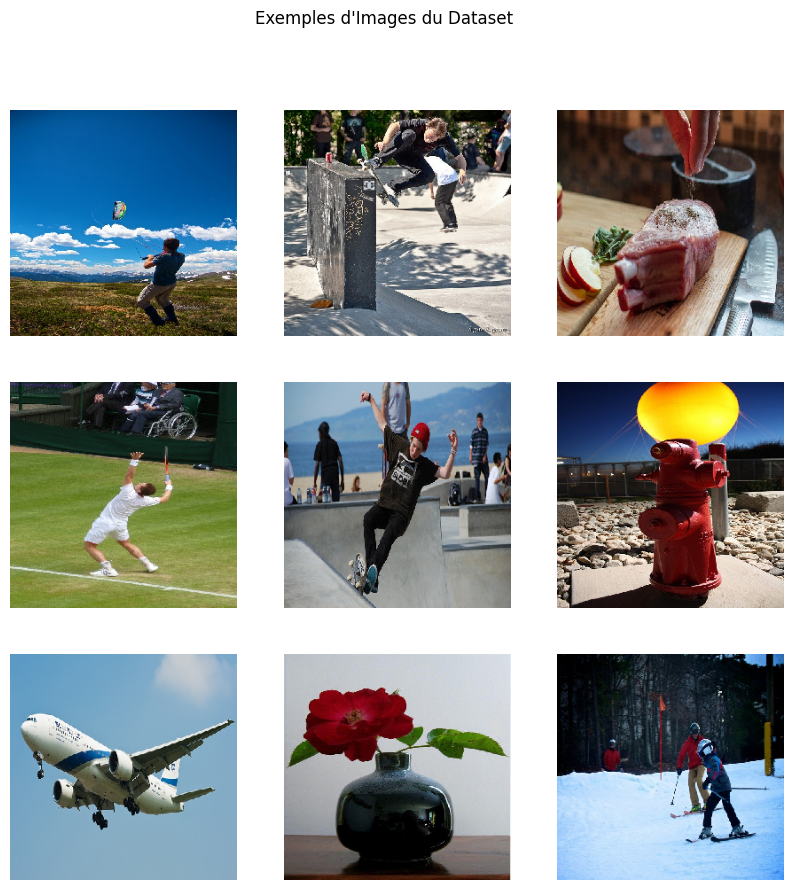

In [178]:
# Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].astype('uint8'))
    plt.axis('off')
plt.suptitle('Exemples d\'Images du Dataset')
plt.show()

## 2.5. Distribution des valeurs de pixel

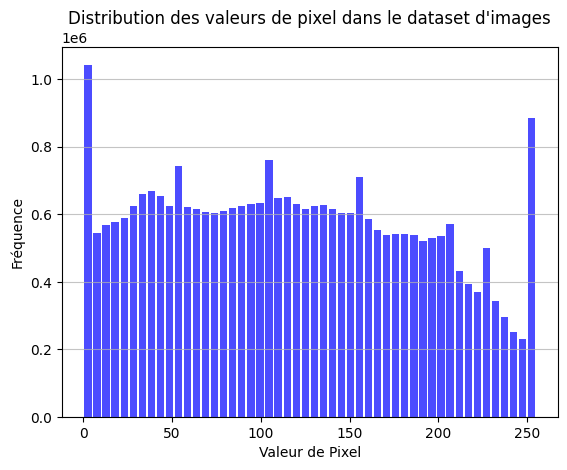

La valeur moyenne des pixels est: 117.62
L'écart-type des valeurs de pixel est: 71.52


In [179]:
# Calculer la distribution des valeurs de pixel
pixel_values = images.flatten()
plt.hist(pixel_values, bins=50, color='blue', alpha=0.7, rwidth=0.8)
plt.title('Distribution des valeurs de pixel dans le dataset d\'images')
plt.xlabel('Valeur de Pixel')
plt.ylabel('Fréquence')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Calculer et afficher la moyenne et l'écart-type des valeurs de pixel
mean_pixel_value = np.mean(pixel_values)
std_pixel_value = np.std(pixel_values)
print(f"La valeur moyenne des pixels est: {mean_pixel_value:.2f}")
print(f"L'écart-type des valeurs de pixel est: {std_pixel_value:.2f}")

* Moyenne des pixels :

La valeur moyenne des pixels de 117.62 suggère que, sur une échelle de 0 (noir) à 255 (blanc), nos images tendent à être d'une luminosité modérée à élevée. Cela pourrait signifier que nos images sont relativement claires, mais avec une présence notable de zones plus sombres puisque la moyenne n'est pas extrêmement élevée.

* Écart-Type des Pixels : 

Un écart-type de 71.52 indique une assez grande variabilité dans les valeurs des pixels à travers l'ensemble des images. Cela signifie que bien que la moyenne des valeurs de pixel soit relativement élevée, il y a une quantité significative de pixels qui sont soit beaucoup plus clairs, soit beaucoup plus sombres que la moyenne.

# 3. Préparation des données

## 3.1. Normalisation des images

On divise toutes les valeurs de pixels par 255, ce qui transforme les valeurs de pixel originales de la plage [0, 255] à [0, 1]. Cette étape permet de modérer les poids et gradients lors de l'entraînement du réseau de neurones, facilitant ainsi la convergence du modèle et améliorant la stabilité du processus d'apprentissage.

In [180]:
# Normaliser les images pour que les valeurs de pixel soient dans [0, 1]
normalized_images = images / 255.0

print("Normalisation terminé.")

Normalisation terminé.


## 3.2. Bruitage artificiel des images

On introduit un bruit artificiel dans les données d'entraînement pour forcer le modèle à apprendre à reconstruire l'image originale à partir de sa version bruitée. 

On a choisi une `noise_factor` de `0.15` après une série d'expérimentations et d'observations. Ce niveau de bruit est suffisant pour introduire un défi pour l'auto-encodeur tout en préservant les caractéristiques clés des images pour que le modèle puisse apprendre efficacement à les reconstruire. 

On va également tester un `noise_factor` de `0.40` afin de vérifier la puissance du modèle en utilisant un bruit nettement plus fort.

In [181]:
# Paramètres pour l'ajout de bruit
noise_factor_015 = 0.15
noise_factor_040 = 0.40

# Ajout d'un bruit gaussien léger aux images
noisy_images_015 = normalized_images + noise_factor_015 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_015 = np.clip(noisy_images_015, 0., 1.)

# Ajout d'un bruit gaussien fort aux images
noisy_images_040 = normalized_images + noise_factor_040 * np.random.normal(loc=0.0, scale=1.0, size=normalized_images.shape)
noisy_images_040 = np.clip(noisy_images_040, 0., 1.)

print("Bruitage terminé.")

Bruitage terminé.


## 3.3. Division en série d'entraînement et de test

On a opté pour une répartition de 80% des données pour l'entraînement et 20% pour le test.

In [182]:
# Diviser les données en ensembles d'entraînement et de test
X_train_015, X_test_015, y_train_015, y_test_015 = train_test_split(
    noisy_images_015,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

# Diviser les données en ensembles d'entraînement et de test
X_train_040, X_test_040, y_train_040, y_test_040 = train_test_split(
    noisy_images_040,   # Entrée (images bruitées)
    normalized_images,  # Cibles (images originales)
    test_size=0.2,
    random_state=42
)

print("Jeux de données constitués")

Jeux de données constitués


## 3.4. Visualisation des images bruitées

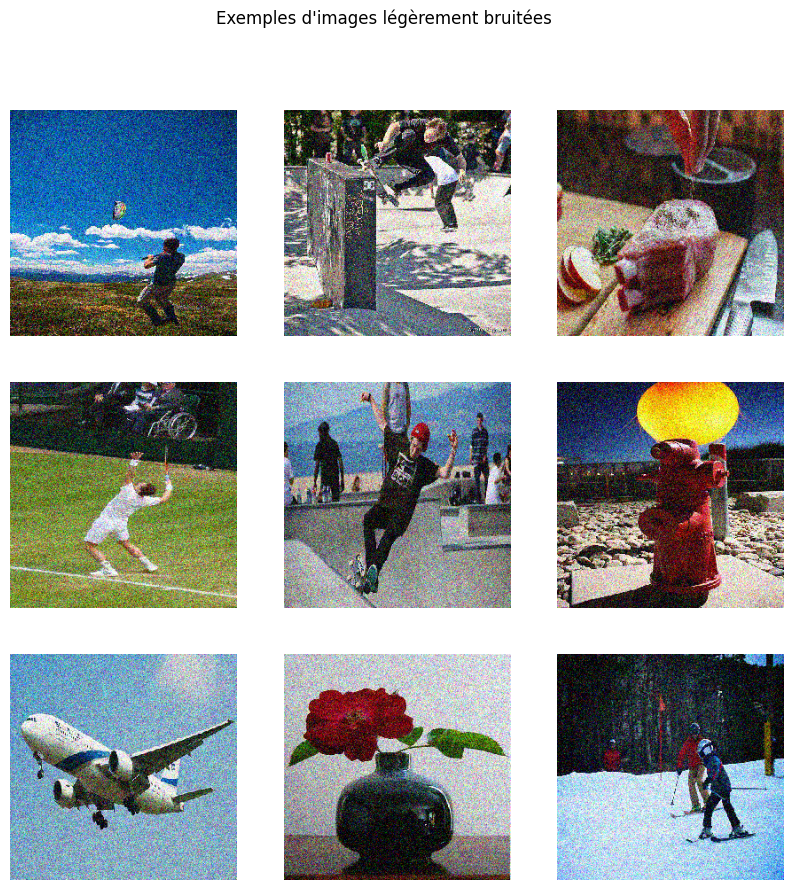

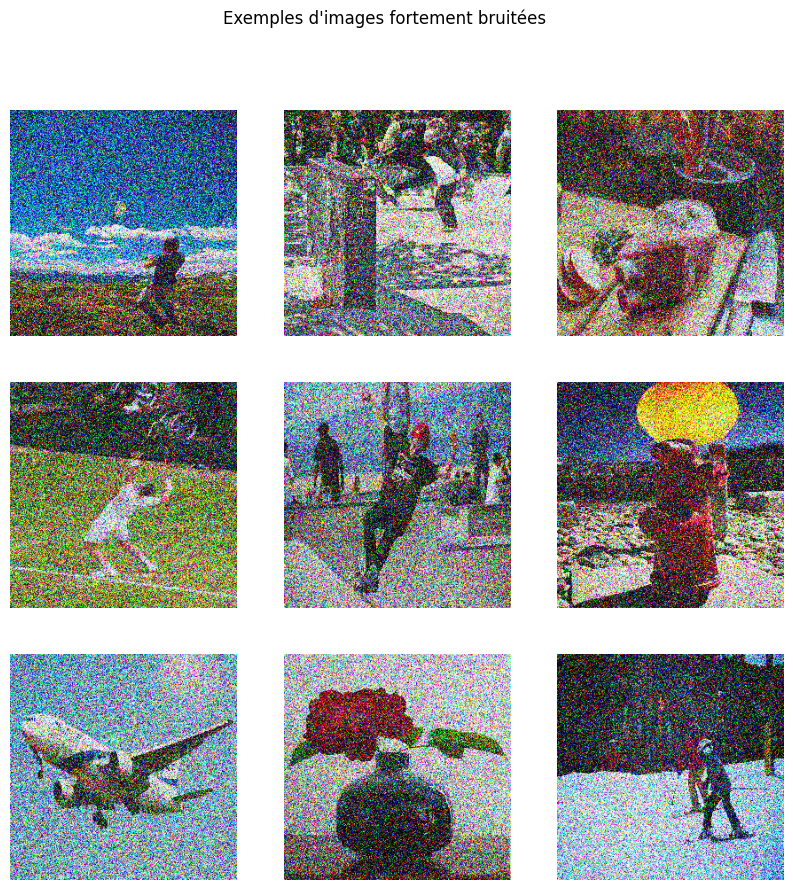

In [183]:
# Afficher quelques images légèrement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_015[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images légèrement bruitées')
plt.show()

# Afficher quelques images fortement bruitées
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(noisy_images_040[i].astype('float32'))
    plt.axis('off')
plt.suptitle('Exemples d\'images fortement bruitées')
plt.show()

# 4. Construction de l'auto-encodeur convolutif

In [184]:
# Définition des images
input_img = Input(shape=(img_height, img_width, rgb))

print("Paramètres appliqués.")

Paramètres appliqués.


## 4.1. Architecture de l'encodeur

On utilise ici une série de couches convolutives et de pooling pour progressivement réduire la dimensionnalité de l'entrée. Les couches convolutives extraient les caractéristiques spatiales des images, tandis que les couches de pooling réduisent les dimensions spatiales (hauteur et largeur), compactant ainsi l'information.

In [185]:
# Paramètres de l'encodeur
encoder_params = [
    {"filters": 64, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"pool_size": (2, 2), "padding": 'same'},
    {"filters": 128, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"pool_size": (2, 2), "padding": 'same'}
]

# Encodeur
x = input_img
for i in range(0, len(encoder_params), 2):
    x = Conv2D(**encoder_params[i])(x)
    x = MaxPooling2D(**encoder_params[i+1])(x)
encoded = x

print("Encodeur paramétré.")

Encodeur paramétré.


## 4.2. Architecture du décodeur

On cherche à reconstruire l'image d'origine via un série de couches convolutives et d'opérations d'upsampling. Les couches convolutives dans le décodeur servent à générer de nouvelles caractéristiques à partir de l'espace latent, tandis que les couches d'upsampling augmentent progressivement la hauteur et la largeur des volumes de sortie. 

In [186]:
# Paramètres du décodeur
decoder_params = [
    {"filters": 128, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"size": (2, 2)},
    {"filters": 64, "kernel_size": (3, 3), "activation": 'relu', "padding": 'same'},
    {"size": (2, 2)},
    {"filters": rgb, "kernel_size": (3, 3), "activation": 'sigmoid', "padding": 'same'}
]

# Décodeur
for i in range(0, len(decoder_params)-1, 2):
    x = Conv2D(**decoder_params[i])(x)
    x = UpSampling2D(**decoder_params[i+1])(x)
x = Conv2D(**decoder_params[-1])(x)
decoded = x

print("Décodeur paramétré.")

Décodeur paramétré.


## 4.3. Modèle d'auto-encodeur complet

In [187]:
# Construction du modèle d'auto-encodeur complet
autoencoder = Model(input_img, decoded)
autoencoder.summary()

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 64, 64, 128)       1475

# 5. Entraînement du modèle

## 5.1. Définition des hyperparamètres

In [188]:
# Paramètres globaux
epochs = 150
batch_size = 4

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    restore_best_weights=True)

print("Hyperparamètres définis.")

Hyperparamètres définis.


## 5.2. Entraînement de l'auto-encodeur

In [189]:
history_015 = autoencoder.fit(
    X_train_015,  # images bruitées
    y_train_015,  # images originales
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_015, y_test_015),
    callbacks=[early_stopping],
)

print("Auto-encodeur 015 entraîné.")

Epoch 1/150
30/30 [==============================] - 4s 55ms/step - loss: 0.6044 - accuracy: 0.4407 - val_loss: 0.5727 - val_accuracy: 0.3748
Epoch 2/150
30/30 [==============================] - 1s 43ms/step - loss: 0.5538 - accuracy: 0.5735 - val_loss: 0.5476 - val_accuracy: 0.6680
Epoch 3/150
30/30 [==============================] - 1s 42ms/step - loss: 0.5412 - accuracy: 0.6565 - val_loss: 0.5429 - val_accuracy: 0.6997
Epoch 4/150
30/30 [==============================] - 1s 42ms/step - loss: 0.5363 - accuracy: 0.6769 - val_loss: 0.5432 - val_accuracy: 0.6904
Epoch 5/150
30/30 [==============================] - 1s 39ms/step - loss: 0.5326 - accuracy: 0.6599 - val_loss: 0.5385 - val_accuracy: 0.7036
Epoch 6/150
30/30 [==============================] - 1s 40ms/step - loss: 0.5328 - accuracy: 0.6819 - val_loss: 0.5425 - val_accuracy: 0.6620
Epoch 7/150
30/30 [==============================] - 1s 40ms/step - loss: 0.5324 - accuracy: 0.6647 - val_loss: 0.5393 - val_accuracy: 0.7006
Epoch 

In [190]:
history_040 = autoencoder.fit(
    X_train_040,  # images bruitées
    y_train_040,  # images originales
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_040, y_test_040),
    callbacks=[early_stopping],
)

print("Auto-encodeur 040 entraîné.")

Epoch 1/150
30/30 [==============================] - 1s 46ms/step - loss: 0.5402 - accuracy: 0.6562 - val_loss: 0.5395 - val_accuracy: 0.6945
Epoch 2/150
30/30 [==============================] - 1s 42ms/step - loss: 0.5305 - accuracy: 0.6713 - val_loss: 0.5363 - val_accuracy: 0.7298
Epoch 3/150
30/30 [==============================] - 1s 42ms/step - loss: 0.5282 - accuracy: 0.7060 - val_loss: 0.5365 - val_accuracy: 0.7054
Epoch 4/150
30/30 [==============================] - 1s 40ms/step - loss: 0.5278 - accuracy: 0.7171 - val_loss: 0.5367 - val_accuracy: 0.7237
Epoch 5/150
30/30 [==============================] - 1s 44ms/step - loss: 0.5281 - accuracy: 0.7001 - val_loss: 0.5356 - val_accuracy: 0.7123
Epoch 6/150
30/30 [==============================] - 1s 40ms/step - loss: 0.5268 - accuracy: 0.7122 - val_loss: 0.5350 - val_accuracy: 0.7204
Epoch 7/150
30/30 [==============================] - 1s 42ms/step - loss: 0.5277 - accuracy: 0.7090 - val_loss: 0.5368 - val_accuracy: 0.7254
Epoch 

## 5.3. Visualisation de la loss durant l'entraînement

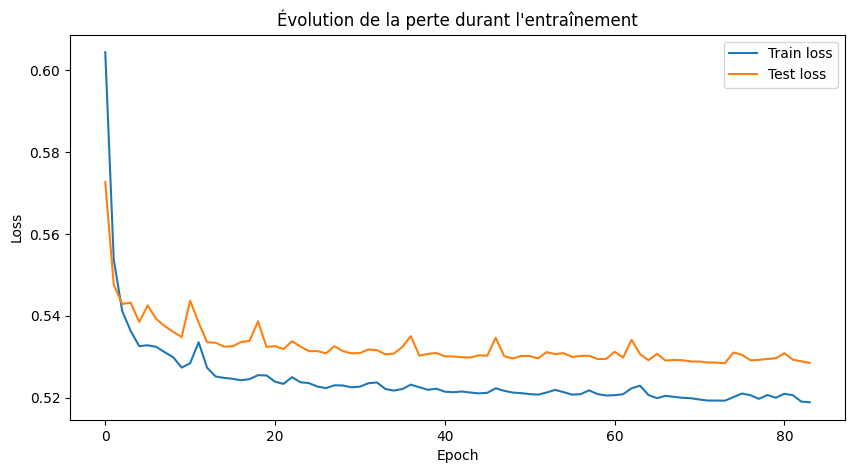

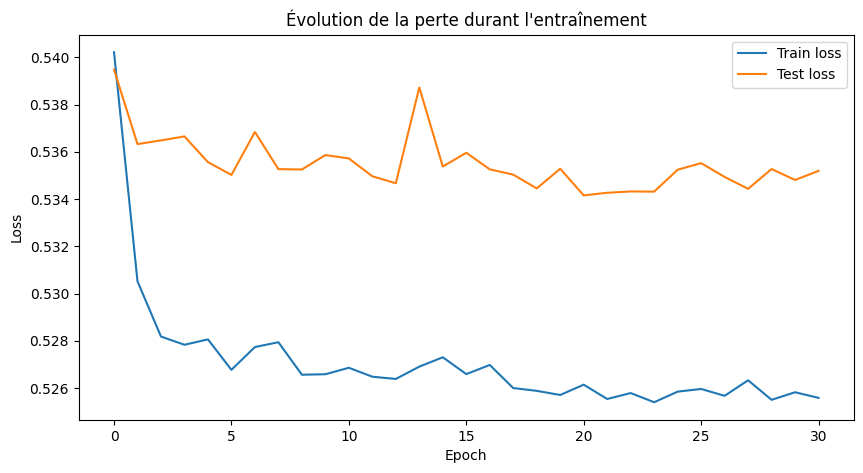

In [191]:
# Tracer l'historique de la perte durant l'entraînement (images légèrement bruitées)
plt.figure(figsize=(10, 5))
plt.plot(history_015.history['loss'], label='Train loss')
plt.plot(history_015.history['val_loss'], label='Test loss')
plt.title('Évolution de la perte durant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer l'historique de la perte durant l'entraînement (images fortement bruitées)
plt.figure(figsize=(10, 5))
plt.plot(history_040.history['loss'], label='Train loss')
plt.plot(history_040.history['val_loss'], label='Test loss')
plt.title('Évolution de la perte durant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5.4. Visualisation de l'accuracy durant l'entraînement

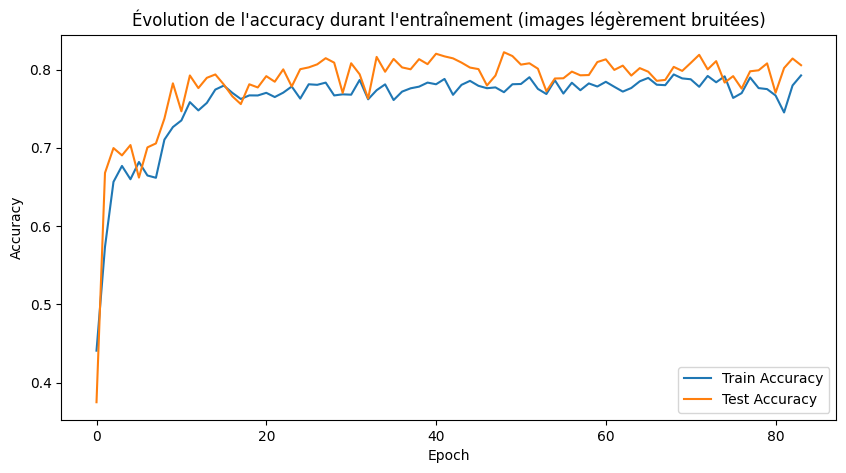

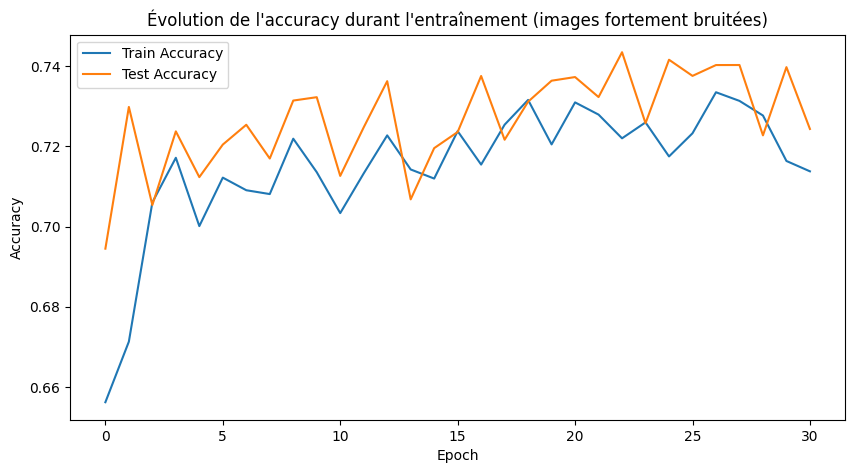

In [192]:
# Tracer l'historique de l'accuracy durant l'entraînement (images légèrement bruitées)
plt.figure(figsize=(10, 5))
plt.plot(history_015.history['accuracy'], label='Train Accuracy')
plt.plot(history_015.history['val_accuracy'], label='Test Accuracy')
plt.title('Évolution de l\'accuracy durant l\'entraînement (images légèrement bruitées)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Tracer l'historique de l'accuracy durant l'entraînement (images fortement bruitées)
plt.figure(figsize=(10, 5))
plt.plot(history_040.history['accuracy'], label='Train Accuracy')
plt.plot(history_040.history['val_accuracy'], label='Test Accuracy')
plt.title('Évolution de l\'accuracy durant l\'entraînement (images fortement bruitées)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. Évaluation du modèle

## 6.1. Évaluation quantitative du modèle sur l'ensemble de test via PSNR

Le **PSNR**, ou Peak Signal-to-Noise Ratio, est une métrique couramment utilisée pour mesurer la qualité d'une image reconstruite par rapport à l'image originale. Il est souvent utilisé dans le contexte de la compression d'images ou de la restauration d'images.

En général, un PSNR plus élevé indique une meilleure qualité. Dans le contexte des images, une valeur de PSNR supérieure à 40 dB est souvent considérée comme une qualité d'image élevée. Une valeur autour de 20-25 dB est considérée comme acceptable. Une valeur en dessous de 20 dB indique généralement une qualité d'image médiocre.

In [193]:
# Prédiction des images débruitées à partir des images bruitées de test
decoded_imgs_015 = autoencoder.predict(X_test_015)
decoded_imgs_040 = autoencoder.predict(X_test_040)

# Initialisation des métriques
psnr_vals = []

# Calcul du PNSR pour les images ayant été légèrement bruitées
for orig, pred in zip(y_test_015, decoded_imgs_015):
    orig = orig.astype("float32")
    pred = pred.astype("float32")
    
    # Calcul et stockage du PSNR pour chaque paire d'images
    psnr_vals.append(psnr(orig, pred, data_range=orig.max() - orig.min()))

# Calcul de la moyenne du PSNR
mean_psnr = np.mean(psnr_vals)
print(f"Mean PSNR (0.15): {mean_psnr:.2f}")

# Réinitialisation des métriques
psnr_vals = []

# Calcul du PNSR pour les images ayant été fortement bruitées
for orig, pred in zip(y_test_040, decoded_imgs_040):
    orig = orig.astype("float32")
    pred = pred.astype("float32")
    
    # Calcul et stockage du PSNR pour chaque paire d'images
    psnr_vals.append(psnr(orig, pred, data_range=orig.max() - orig.min()))

# Calcul de la moyenne du PSNR
mean_psnr = np.mean(psnr_vals)
print(f"Mean PSNR (0.40): {mean_psnr:.2f}")

1/1 [==============================] - 0s 24ms/step
Mean PSNR (0.15): 16.23
Mean PSNR (0.40): 22.17


**PSNR (0.15) = 16.23** : Une valeur de PSNR de 16.23 dB pour les images légèrement bruitées suggère une qualité modérée de reconstruction. Ainsi, ce résultat suggère que la qualité de reconstruction pourrait être améliorée.

**PSNR (0.40) = 22.17** : Une valeur de PSNR de 22.17 dB pour les images fortement bruitées est meilleure que celle pour les images légèrement bruitées. Cela suggère que le modèle a mieux performé sur les images fortement bruitées par rapport aux images légèrement bruitées, ce qui est un peu contre-intuitif. Habituellement, on s'attend à ce que le modèle performe moins bien sur des images avec un bruit plus fort.

## 6.2. Évaluation quantitative du modèle sur l'ensemble de test via MSE

Le **MSE**, ou Mean Squared Error, est une métrique de performance couramment utilisée pour mesurer l'erreur entre des valeurs prévues et des valeurs réelles. Dans le contexte de la reconstruction d'images (comme avec des auto-encodeurs), il quantifie l'écart entre les images reconstruites et les images originales.

In [2]:
# Calcul du MSE pour les images légèrement bruitées
mse_vals_015 = [mean_squared_error(orig.flatten(), pred.flatten()) for orig, pred in zip(y_test_015, decoded_imgs_015)]
mean_mse_015 = np.mean(mse_vals_015)
print(f"Mean MSE (0.15): {mean_mse_015:.3f}")

# Calcul du MSE pour les images fortement bruitées
mse_vals_040 = [mean_squared_error(orig.flatten(), pred.flatten()) for orig, pred in zip(y_test_040, decoded_imgs_040)]
mean_mse_040 = np.mean(mse_vals_040)
print(f"Mean MSE (0.40): {mean_mse_040:.3f}")

NameError: name 'y_test_015' is not defined

On obtient les résultats suivant : 

**MSE (0.15) = 0.007** : Cette valeur est relativement faible, indiquant une différence mineure entre les images reconstruites et les originales.

**MSE (0.40) = 0.026** : Cette valeur est plus élevée que la première, indiquant une plus grande différence entre les images reconstruites et les originales.

## 6.3. Visualisation des images débruitées

In [1]:
# Affichage des images originales, bruitées et débruitées
plt.figure(figsize=(20,20))
num_images_to_show = 6

for i in range(num_images_to_show):
    # Images originales
    ax = plt.subplot(5, num_images_to_show, i + 1)
    plt.imshow(y_test_015[i].reshape(img_height, img_width, rgb))
    plt.title("Original")
    plt.axis("off")
    
    # Images légèrement bruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(X_test_015[i].reshape(img_height, img_width, rgb))
    plt.title("Bruité (0.15)")
    plt.axis("off")

    # Images fortement bruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 2*num_images_to_show)
    plt.imshow(X_test_040[i].reshape(img_height, img_width, rgb))
    plt.title("Bruité (0.40)")
    plt.axis("off")
    
    # Images légèrement bruitées débruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 3*num_images_to_show)
    plt.imshow(decoded_imgs_015[i].reshape(img_height, img_width, rgb))
    plt.title("Débruité (0.15)")
    plt.axis("off")

    # Images fortement bruitées débruitées
    ax = plt.subplot(5, num_images_to_show, i + 1 + 4*num_images_to_show)
    plt.imshow(decoded_imgs_040[i].reshape(img_height, img_width, rgb))
    plt.title("Débruité (0.40)")
    plt.axis("off")

plt.suptitle("Image reconstruction by autoencoder")
plt.show()

NameError: name 'plt' is not defined

On observe que l'image légèrement bruitée a été fidèlement reconstruite étant donné le faible niveau de bruit initial. La différence avant et après reconstruction est moins marquée. Par contre, la reconstruction de l'image fortement bruitée est moins précise, ce qui est attendu étant donné le niveau de bruitage initial assez élevé.